<a href="https://colab.research.google.com/github/nicolashernandez/teaching_nlp/blob/main/05_Classification_de_textes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de textes

La **classification** consiste à attribuer une classe à chaque texte (objet, instance, point) à classer. On parle de *classification binaire* (_binary classification_) quand il y a deux classes exclusives. On parle de *classification en classes multiples* (_multiclass classification_) pour désigner la répartition d'un lot de textes entre plus de deux ensembles (ou classes), une classe par instance. On parle de *classification multi-étiquettes* (_multi-label classification_) pour désigner les problèmes de classification où plusieurs étiquettes (classes) peuvent être assignées à une même instance.

Reconnaître si un email est un spam, si une photo contient une voiture... sont des problèmes de classification (binaire).


# Sentiment analysis as a classification task


La tâche classique d'analyse de sentiment consiste à annoter un texte donné selon une polarité positive ou négative exprimée dans le texte.


## QUESTION

* Selon vous la tâche d'analyse de sentiment tel que définie juste au dessus peut se définir comme un problème de 1) classification binaire, 2) classification en classes multiples ou 3) en classification multi-étiquettes ?

## VOTRE REPONSE

**TODO**


# Configuration de l'environnement Google Colab en mode GPU


Quel mode d'exécution utilisez-vous (via GPU ou via CPU) ? Que vous dis le code ci-dessous ?

In [1]:
# memory footprint support libraries/code
# https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed

def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
#

if len(GPUs) >0: 
  gpu = GPUs[0]
  printm()
else:
  print ('no GPU. Are you sure the hardware accelerator is configured to GPU? To do this go to Runtime→Change runtime type and change the Hardware accelerator to GPU.') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=dda6586fe8d6896cb65d4ae5045626d99e0434a9ba4218a03230d662e0a57706
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.8 GB  | Proc size: 87.1 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


Configurez votre mode d'exécution du Google Colab en mode GPU.

> To use the google colab in a GPU mode you have to make sure the hardware accelerator is configured to GPU. To do this go to Runtime→Change runtime type and change the Hardware accelerator to GPU. Sometimes, all GPUs are in use and there is no GPU available.

Une fois configuré le GPU, vérifiez l'état de la mémoire sur la carte en réexécutant le code "memory footprint" ci-dessus. Le message a-t-il changé favorablement ?

Le mode d'exécution GPU est nécessaire pour le fine-tuning de BERT ci-dessous. 

# Allociné dataset

The [Allociné dataset](https://huggingface.co/datasets/allocine) is a French-language dataset for sentiment analysis. The texts are movie reviews written between 2006 and 2020 by members of the Allociné.fr community for various films. It contains 100k positive and 100k negative reviews divided into train (160k), validation (20k), and test (20k). 


### From huggingface datahub

After execution of this cell, you must restart the runtime in order to use  newly installed versions.

Just click on the button on the suggester "restart runtime" button (or go the runtime menu).

In [11]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieve the [allociné dataset](https://huggingface.co/datasets/allocine) from the huggingface hub.

In [1]:
# https://huggingface.co/datasets/allocine

from datasets import load_dataset_builder
ds_builder = load_dataset_builder("allocine")

# Inspect dataset description
print(ds_builder.info.description)

# Inspect dataset features
print(ds_builder.info.features)

# get_dataset_split_names
from datasets import get_dataset_split_names
get_dataset_split_names("allocine")

# load_dataset
from datasets import load_dataset
allocine_dataset = load_dataset("allocine")
allocine_dataset
#train_dataset = load_dataset("allocine", split="train")

 Allocine Dataset: A Large-Scale French Movie Reviews Dataset.
 This is a dataset for binary sentiment classification, made of user reviews scraped from Allocine.fr.
 It contains 100k positive and 100k negative reviews divided into 3 balanced splits: train (160k reviews), val (20k) and test (20k).

{'review': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)}


Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset allocine downloaded and prepared to /root/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

#### Select data ratio to process and create Pandas DataFrame

Definition of a method to select a ratio of a dataset split. By default return 100 % of the split.

In [2]:
import numpy as np

def get_dataset_split_ratio(dataset_split, seed=42, ratio=100):
  if ratio > 100 or ratio < 1: ratio = 100
  reviews = dataset_split['review']
  labels = dataset_split['label']
  
  data = [pair for pair in zip(reviews, labels)]
  
  np.random.seed(seed)
  np.random.shuffle(data)
  
  ratio_len = int(len(data)*ratio/100)
  
  data = list(zip(*data))

  return {'review':data[0][:ratio_len], 'label':data[1][:ratio_len]}


Definition of the method to create a dataframe from a huggingface dataset split (`{'review':[], 'label':[]}`) :

In [3]:
import pandas as pd

# From huggingface dataset split to DataFrame
def hf_dataset_split_to_df (huggingface_dataset_split):
  df = pd.DataFrame(huggingface_dataset_split)
  # https://github.com/amaiya/ktrain/blob/master/examples/text/ArabicHotelReviews-nbsvm.ipynb
  df['label'] = df['label'].apply(lambda x: 'negative' if x == 0 else 'positive')
  df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
  df = df[['review', 'negative', 'positive']]
  return df

Sélectionner la taille des données sur lesquelles vous voulez travailler et construire la dataframe correspondante.

Le code ci-dessous extrait 5 % du corpus. C'est suffisant pour étudier comment fonctionne les modèles présentés ci-après sans attendre trop de temps d'entraînement.

In [4]:
ratio = 5 # percent of the data

train_df = hf_dataset_split_to_df(get_dataset_split_ratio(allocine_dataset['train'], 42, ratio))
val_df = hf_dataset_split_to_df(get_dataset_split_ratio(allocine_dataset['validation'], 42, ratio))
test_df = hf_dataset_split_to_df(get_dataset_split_ratio(allocine_dataset['test'], 42, ratio))

print(train_df.head())
print(train_df.describe())
print('len(train_df) :', len(train_df))
print('len(val_df) :', len(val_df))
print('len(test_df) :', len(test_df))

                                              review  negative  positive
0  Un excellent thriller d'action où les scènes d...         0         1
1  Si le scénariste, qui aurait pu faire un minim...         1         0
2  Référence dans la filmographie de Bogart, "Le ...         1         0
3  Un bon scénario, un bon film, une histoire lou...         0         1
4  Un scenario vide et une mise en scene trés sop...         1         0
          negative     positive
count  8000.000000  8000.000000
mean      0.491125     0.508875
std       0.499952     0.499952
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000
len(train_df) : 8000
len(val_df) : 1000
len(test_df) : 1000


# ktrain

[ktrain](https://github.com/amaiya/ktrain) a lightweight wrapper for the deep learning library _TensorFlow Keras_ (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, ktrain is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.


## Configuration et installation de ktrain

Configuration de l'environnement

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Installation de la bibliothèque ktrain

In [8]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import de la bibliothèque ktrain dédié aux traitements de la modalité textuelle

In [9]:
# Execution time 30 s
import ktrain
from ktrain import text

## Fonctionnement de ktrain


Pour réaliser cette tâche de classification nous allons utiliser la bibliothèque ktrain pour faire un apprentissage par transfert.

Les étapes sont les suivantes
1. chargement des données avec application d'un prétraitement défini à la volée
2. construction d'un modèle de classification sur la base d'un modèle pré-entraîné spécifié
3. récupération d'une instance du modèle pour la personnalisation de celui-ci
4. recherche d'un bon taux d'apprentissage
5. entraînement du classifieur i.e. personnalisation du modèle de base à l'aide d'un taux d'apprentissage défini
6. utilisation du nouveau modèle

*ETAPE 1 :* 

Le type de pré-traitement est fonction du modèle pré-entraîné spécifié.

*ETAPE 2 :*

ktrain vient avec quelques modèles pré-entraînés packagés. Pour les connaître, exécutez : 

In [10]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


Vous connaissez **[fasttext](https://github.com/facebookresearch/fastText)** de (Facebook/Meta) car vous l'avez déjà utilisé dans un [précédent TP](https://github.com/nicolashernandez/teaching_nlp/blob/main/04_repr%C3%A9sentation_vectorielle_continue.ipynb)... fasttext permet de produire une représentation continue des mots en suivant une approche à la word2vec. Sa spécificité est qu'il propose de traiter la variabilité morphologique des mots en construisant des vecteurs non pas pour des mots mais pour des sous-mots (séquence de caractères). Le vecteur d'un mot est la somme de tous les vecteurs des sous-mots le composant. Cette approche est indépendante de la langue, et montre de meilleurs résultats que word2vec sur des tâches syntaxiques, surtout quand le corpus d'entraînement est petit. Word2vec est légèrement meilleur pour des tâches sémantiques. Un des avantage de FastText est de pouvoir fournir des vecteurs mêmes pour les mots hors vocabulaires.



[**NBSVM**](https://medium.com/@asmaiya/a-neural-implementation-of-nbsvm-in-keras-d4ef8c96cb7c) is an approach to text classification proposed by [Wang and Manning](https://www.aclweb.org/anthology/P12-2018) that takes a linear model such as SVM (or logistic regression) and infuses it with Bayesian probabilities by replacing word count features with Naive Bayes log-count ratios. Despite its simplicity, NBSVM models have been shown to be both fast and powerful across a wide range of different text classification datasets. 
Keras offers a NBSVM model implemented as a neural network using two embedding layers. The first stores the Naive Bayes log-count ratios. The second stores learned weights (or coefficients) for each feature (i.e., word) in this linear model. The prediction, then, is simply the dot product of these two vectors.

**BERT** (_Bidirectional Encoder Representations from Transformers_), proposé par [Google AI Language](https://arxiv.org/pdf/1810.04805.pdf) est un encodeur bidirectionnel qui applique un modèle d'attention Transformers à la modélisation du language (_language modeling_). Il représente l'état de l'art.
Les Transformers sont un mécanisme d'attention qui apprennent les relations contextuelles entre les mots dans un texte.


Il est possible d'[**encapsuler les modèles Transformers du site _hugging face_**](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb). _hugging face_ diffuse les [modèles Transformers pré-entraînés "officiels"](https://huggingface.co/transformers/pretrained_models.html) ainsi que les [modèles Transformers construits par la communauté](https://huggingface.co/models).


*ETAPE 4 :*


Le **taux d'apprentissage (_learning rate_)** est un hyperparamètre qui contrôle combien le modèle doit changer en réponse à l'erreur estimée à chaque fois que les poids du modèles sont mis à jour. Choisir un 'lr' trop petit conduit à une longue phase d'entraînement qui peut resté bloquée. Choisir un 'lr' trop grand conduit à un apprentissage sous-optimal des poids et à une instabilité du processus d'entraînement. 

  

## FastText



*ETAPE 1 :* 

Les méthodes [`texts_from_csv`](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_csv) ou [`texts_from_df`](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_df) charge le corpus, normalise les documents (définit un préprocesseur réutilisable), et découpe la collection en données d'entraînement et données de validation (à moins que des données de validation soient passées en argument).

Cette étape est commune aux modèles FastText et NBSVM (`preprocess_mode='standard'`). BERT utilise son propre tokenizer. Il faudra faire un pré-traitement dédié (`preprocess_mode='bert'`).

```
* train_filepath(str): file path to training CSV
* text_column(str): name of column containing the text
* label_column(list): list of columns that are to be treated as labels
* val_filepath(string): file path to test CSV.  If not supplied, 10% of documents in training CSV will be used for testing/validation.
* max_features(int): max num of words to consider in vocabulary ; Note: This is only used for preprocess_mode='standard'.
* maxlen(int): each document can be of most <maxlen> words. 0 is used as padding ID.
* ngram_range(int): size of multi-word phrases to consider e.g., 2 will consider both 1-word phrases and 2-word phrases limited by max_features
* preprocess_mode (str):  Either 'standard' (normal tokenization) or one of {'bert', 'distilbert'} tokenization and preprocessing for use with                BERT/DistilBert text classification model.
```



        
  

In [11]:
# fasttext
#NUM_WORDS = 50000
#MAXLEN = 150
#NGRAMS_SIZE = 1# 1 # 8 minutes avec 2 pour 10000 examples

# nbsvm 
#NUM_WORDS = 80000
#MAXLEN = 2000
#NGRAMS_SIZE = 3

(x_train_preproc, y_train_preproc), (x_val_preproc, y_val_preproc), preproc = text.texts_from_df (train_df, 
                                                                   'review', # name of column containing review text
                                                                   label_columns=['negative', 'positive'],
                                                                   val_df=val_df, # if None, 10% of data will be used for validation
                                          #max_features=NUM_WORDS, 
                                          #maxlen=MAXLEN,
                                          #ngram_range=NGRAMS_SIZE,
                                          preprocess_mode='standard' # default
                                          )



['negative', 'positive']
   negative  positive
0         0         1
1         1         0
2         1         0
3         0         1
4         1         0
['negative', 'positive']
   negative  positive
0         0         1
1         0         1
2         1         0
3         1         0
4         1         0
language: fr
Word Counts: 44776
Nrows: 8000
8000 train sequences
train sequence lengths:
	mean : 87
	95percentile : 239
	99percentile : 305
x_train shape: (8000,400)
y_train shape: (8000, 2)
Is Multi-Label? False
1000 test sequences
test sequence lengths:
	mean : 89
	95percentile : 247
	99percentile : 303
x_test shape: (1000,400)
y_test shape: (1000, 2)


Observons les 5 premières des données prétraitées. `x_` représente la donnée et `y_` la classe. On note que les données ont été transformées. Chaque mot est remplacé par un identifiant. On note que la classe est décrite par 2 colonnes avec deux codes "1 0" et "0 1".

In [12]:
print ('x_train_preproc', x_train_preproc[:5])
print ('y_train_preproc', y_train_preproc[:5])

x_train_preproc [[    0     0     0 ...   838     1  2855]
 [    0     0     0 ...     8     1   766]
 [    0     0     0 ...  2425     1     4]
 [    0     0     0 ...   453   368   707]
 [    0     0     0 ... 10369    46    85]]
y_train_preproc [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


*ETAPE 2 et 3:* 


In [13]:
# Build and return a text classification model https://amaiya.github.io/ktrain/text/index.html#ktrain.text.text_classifier
fasttext_model = text.text_classifier('fasttext', (x_train_preproc, y_train_preproc), preproc=preproc)

# Returns a Learner instance that can be used to tune and train Keras models https://amaiya.github.io/ktrain/index.html#ktrain.get_learner
fasttext_learner = ktrain.get_learner(fasttext_model, train_data=(x_train_preproc, y_train_preproc), val_data=(x_val_preproc, y_val_preproc))

Is Multi-Label? False
compiling word ID features...
maxlen is 400
done.


*ETAPE 4 :* 

La méthode [`lr_find`](https://amaiya.github.io/ktrain/core.html#ktrain.core.Learner.lr_find) implémente la méthode [*Cyclical Learning Rates*](https://arxiv.org/abs/1506.01186) qui permet d'estimer un lr sans une exploration systématique d'un lr qui décroit. L'approche peut prendre seulement le temps de quelques itérations (i.e. du traitement de quelques batchs) sans même tourner sur plusieurs époques. Pour rappel, une époque correspond au traitement de l'ensemble des données d'entrainements par lot/batch d'exemples. *For example,
CIFAR-10 has 50, 000 training images and the batchsize is
100 so an epoch = 50, 000/100 = 500 iterations*. 

Then plots loss as learning rate is increased.

*Highest learning rate corresponding to a still falling loss should be chosen*. "[The point of optimality [...] is the point on the training rate plot where the slope is steepest in the downwards direction. That's because this plot shows the loss after one epoch. Points before the steepest slope are training too slowly. Points after the steepest slope are at risk of training too quickly: usually, but not always (it didn't happen in this demo case), they will fall off the mountain in terms of loss because they jump past the point of optimality](https://www.kaggle.com/code/residentmario/finding-an-optimal-learning-rate-with-lr-finder)".

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
250/250 [==============================] - 6s 5ms/step - loss: 1.0193 - accuracy: 0.4921
Epoch 2/1024
250/250 [==============================] - 1s 4ms/step - loss: 1.0010 - accuracy: 0.5008
Epoch 3/1024
250/250 [==============================] - 1s 5ms/step - loss: 0.9663 - accuracy: 0.5101
Epoch 4/1024
250/250 [==============================] - 1s 5ms/step - loss: 0.8285 - accuracy: 0.5573
Epoch 5/1024
250/250 [==============================] - 1s 4ms/step - loss: 0.5645 - accuracy: 0.7176
Epoch 6/1024
250/250 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.6304
Epoch 7/1024
250/250 [==============================] - 1s 5ms/step - loss: 0.7795 - accuracy: 0.4965
Epoch 8/1024
250/250 [==============================] - 0s 854us/step - loss: 11538.7305 - accuracy: 0.5000


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help id

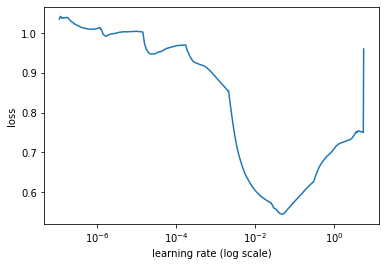

In [14]:
# recherche d'un bon taux d'apprentissage 
# you can set max_epochs (e.g., max_epochs=5) to estimate LR
fasttext_learner.lr_find() # 
fasttext_learner.lr_plot()

*ETAPE 5 :* 

[autofit](https://amaiya.github.io/ktrain/core.html#ktrain.core.Learner.autofit)
Automatically train model using a default learning rate schedule shown to work well in practice.  By default, this method currently employs a triangular learning rate policy (https://arxiv.org/abs/1506.01186).  
During each epoch, this learning rate policy varies the learning rate from lr/10 to lr and then back to a low learning rate that is near-zero. 
If epochs is None, then early_stopping and reduce_on_plateau are atomatically
set to 6 and 3, respectively.


#### QUESTION : training

* Sur le graph ci-dessus, repérez approximativement la puissance `n` de `1/10^n` où la chute de la loss devient importante. Testez avec cette valeur comme learning rate, observez votre performance (accuracy) sur le train et le val.

Dans l'extrait de log ci-dessous, loss et accuracy concerne le corpus de train tandis que  val_loss et val_accuracy le corpus de validation (sur un corpus sample).
```
Epoch 12/1024
244/250 [============================>.] - ETA: 0s - loss: 0.1109 - accuracy: 0.9589
Restoring model weights from the end of the best epoch: 7.
250/250 [==============================] - 1s 6ms/step - loss: 0.1108 - accuracy: 0.9589 - val_loss: 0.3864 - val_accuracy: 0.8820
Epoch 12: early stopping
```
* Est-ce normal d'observer un écart d'accuracy entre le train et le val ?
* Stoquez le score obtenu en dernière étape, et relancez le finetuning sans changer le paramétrage. Obtenez-vous les mêmes résultats ? Pourquoi ? La réponse est à chercher dans l'initiatilisation des poids du réseau neuronal.
* Volontairement (et selon le temps qu'a pris votre entraînement) testez des lr avec d'autres puissances de 10 (0.1, 0.01, 0.001, 0.0001). Attention les lr les plus petites prendront le plus de temps !!! Est-ce que cela marche mieux ? Attention, suivant votre choix de lr l'entraînement peut prendre quelques minutes à au moins 1h....

Mon meilleur score est `loss: 0.1108 - accuracy: 0.9589 - val_loss: 0.3864 - val_accuracy: 0.8820` sur le corpus sample et vous ?

In [15]:
LEARNING_RATE = 0.01

fasttext_learner.autofit(LEARNING_RATE)
# Epoch 16/1024
# 4491/4500 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9418Restoring model weights from the end of the best epoch: 11.
# 4500/4500 [==============================] - 25s 6ms/step - loss: 0.1539 - accuracy: 0.9418 - val_loss: 0.2173 - val_accuracy: 0.9206
# Epoch 16: early stopping

# wi all allocine training dataset (at least one hour run) 
#learner.autofit(0.00001)
# Epoch 129/1024
# 4497/4500 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9135Restoring model weights from the end of the best epoch: 124.
# 4500/4500 [==============================] - 29s 6ms/step - loss: 0.2197 - accuracy: 0.9135 - val_loss: 0.2058 - val_accuracy: 0.9204
# Epoch 129: early stopping

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
250/250 [==============================] - 2s 7ms/step - loss: 0.6729 - accuracy: 0.6395 - val_loss: 0.5420 - val_accuracy: 0.7750
Epoch 2/1024
250/250 [==============================] - 2s 6ms/step - loss: 0.4354 - accuracy: 0.8031 - val_loss: 0.3564 - val_accuracy: 0.8410
Epoch 3/1024
250/250 [==============================] - 2s 6ms/step - loss: 0.3448 - accuracy: 0.8585 - val_loss: 0.3259 - val_accuracy: 0.8650
Epoch 4/1024
250/250 [==============================] - 2s 6ms/step - loss: 0.2955 - accuracy: 0.8746 - val_loss: 0.3221 - val_accuracy: 0.8670
Epoch 5/1024
250/250 [==============================] - 2s 6ms/step - loss: 0.2605 - accuracy: 0.8911 - val_loss: 0.3332 - val_accuracy: 0.8650
Epoch 6/1024
250/250 [==============================] - 2s 6ms/step - loss: 0.2260 - accuracy: 0.

#### VOTRE REPONSE

**TODO**

MODEL BACKUP AND LOAD

Le code ci-dessous vous permet de sauver votre modèle pour des usages ultérieurs (il faudra ensuite le télécharger). Cela peut être utile pour des modèles construits sur la totalité des données.

In [16]:
import pickle
with open('fasttext_allocine.model', 'wb') as model_file:
  pickle.dump(fasttext_learner, model_file)

Le code suivant permet de charger un modèle (peut-être faudra t-il réexécuter jusqu'à l'étape 2-3).

In [17]:
import pickle

# open a file, where you stored the pickled data
with open('fasttext_allocine.model', 'rb') as model_file:
  # load information to that file
  fasttext_learner = pickle.load(model_file)

*ETAPE 6 :* Le code ci-dessous permet d'utiliser le modèle. Notez que le paramétrage `return_proba=True` permet d'obtenir les probas... 

In [18]:
fasttext_predictor = ktrain.get_predictor(fasttext_learner.model, preproc)

data = [ "Ce film était horrible ! L'intrigue était ennuyeuse. Le jeu d'acteur était correct, cependant.",
         "Le film est vraiment nul. Je veux qu'on me rende mon argent.",
        "Quelle belle comédie romantique. 10/10 à revoir !"]

# Makes predictions for a list of strings where each string is a document or text snippet.
print (fasttext_predictor.predict(data))

# If return_proba is True, returns probabilities of each class.
print (fasttext_predictor.predict(data,  return_proba=True))

['negative', 'negative', 'positive']
[[9.9993157e-01 6.8429981e-05]
 [9.9803478e-01 1.9652788e-03]
 [9.0821311e-03 9.9091786e-01]]


#### QUESTION : évaluation qualitative légère

* Tester le modèle. Arrivez-vous à piéger le modèle ? Avec quelle phrase (donnez le code)

#### VOTRE REPONSE

**TODO**

### QUESTION : Evaluation quantitative

Génération d'une hypothèse pour les *review* du corpus de test (`list(test_df['review'])`)

In [38]:
# reviews 
x_test = list(test_df['review'])

# labels (gold) 
y_test = list(test_df['positive'])

In [39]:
# hypothèse
y_hyp = [0 if h == 'negative' else 1 for h in fasttext_predictor.predict(x_test) ]



[SemEval 2022 isarcasmeval task](https://sites.google.com/view/semeval2022-isarcasmeval) used the F1-score for the sarcastic class. sklearn permet de spécifier cette mesure avec le paramètre `average = 'binary'` éventuellement accompagné du paramètre qui indique la classe à considérer `pos_label = 1`. This metric should not be confused with the regular macro-F1. sklearn permet de calculer un score macro à l'aide de la valeur `average = 'macro'`.
Sans paramétrage c'est le F1-score d'une classe qui est retourné. Les performances rapportées par [Theophile Blart utilise aussi ce paramétrage par défaut](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert).

In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_positive = f1_score(y_test, y_hyp, average = "binary", pos_label = 1)
f1_positive
#OR
#p_score_positive = precision_score(y_test, y_hyp, average = "binary", pos_label = 1)
#r_score_positive = recall_score(y_test, y_hyp, average = "binary", pos_label = 1)
#f1_positive = (2*p_score_positive*r_score_positive)/(p_score_positive +r_score_positive)

# f1_positive 10000 0.8708333333333333
# f1 10000 0.8759157069737684

0.8922764227642277

[Theophile Blard rapporte des performances avec différents modèles (CamemBERT, RNN, TF-IDF + LogReg, CNN, fastText (unigrams)) sur le dataset Allociné](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert). Comment vous positionnez-vous par rapport à ses résultats ?   

## NBSVM

Le code ci-dessous utilise le même pré-traitement que précédemment et applique un modèle neuronal plus "simple" que fasttext.  

In [36]:
# load an NBSVM model
nbsvm_model = text.text_classifier('nbsvm', (x_train_preproc, y_train_preproc), preproc=preproc)
nbsvm_learner = ktrain.get_learner(nbsvm_model, train_data=(x_train_preproc, y_train_preproc), val_data=(x_val_preproc, y_val_preproc))

# fine tune
LEARNING_RATE = 0.01
nbsvm_learner.autofit(LEARNING_RATE)
# Epoch 6/1024
#4498/4500 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9544Restoring model weights from the end of the best epoch: 1.
#4500/4500 [==============================] - 24s 5ms/step - loss: 0.1264 - accuracy: 0.9544 - val_loss: 0.2677 - val_accuracy: 0.9161
#Epoch 6: early stopping

# Finally, we will fit our model using and [SGDR learning rate](https://github.com/amaiya/ktrain/blob/master/example-02-tuning-learning-rates.ipynb) schedule by invoking the fit method with the cycle_len parameter (along with the cycle_mult parameter).
# learner.fit(0.001, 3, cycle_len=1, cycle_mult=2)


Is Multi-Label? False
compiling word ID features...
maxlen is 400
building document-term matrix... this may take a few moments...
rows: 1-8000
computing log-count ratios...
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
250/250 [==============================] - 2s 6ms/step - loss: 0.3299 - accuracy: 0.8939 - val_loss: 0.2799 - val_accuracy: 0.8980
Epoch 2/1024
250/250 [==============================] - 1s 5ms/step - loss: 0.1469 - accuracy: 0.9622 - val_loss: 0.2646 - val_accuracy: 0.9020
Epoch 3/1024
250/250 [==============================] - 1s 5ms/step - loss: 0.1023 - accuracy: 0.9766 - val_loss: 0.2740 - val_accuracy: 0.8980
Epoch 4/1024
247/250 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9837
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).
250/250 [========

évaluation

In [41]:
# données
x_test = list(test_df['review']) # reviews 
y_test = list(test_df['positive']) # labels (gold) 

# prédiction
nbsvm_predictor = ktrain.get_predictor(nbsvm_learner.model, preproc)
y_hyp = [0 if h == 'negative' else 1 for h in nbsvm_predictor.predict(x_test) ]

# évaluation
print(f1_score(y_test, y_hyp))

0.903981180311341


backup model

In [ ]:
import pickle
with open('nbsvm_allocine.model', 'wb') as model_file:
  pickle.dump(nbsvm_learner, model_file)

#### QUESTION

* Le modèle nbsvm est-il plus performant que le précédent sur les données de validations ? Vous pouvez tester aussi différents learning rate.

## BERT 

L'usage du modèle bert requiert que l'on change le prétraitement des données en entrée. Le code suivant réalise le prétraitement, charge un modèle bert et lance la personnalisation (fine tuning) sur 1 cycle avec taux d'apprentissage fixé.


In [42]:
# ETAPE 1 
(x_train_preproc, y_train_preproc), (x_val_preproc, y_val_preproc), preproc = text.texts_from_df (train_df, 
                      'review',
                      label_columns = ["negative", "positive"],
                      val_df= val_df, # if None, 10% of data will be used for validation
                      ##max_features=NUM_WORDS, 
                      #maxlen=MAXLEN,
                      preprocess_mode='bert' 
                      )

['negative', 'positive']
   negative  positive
0         0         1
1         1         0
2         1         0
3         0         1
4         1         0
['negative', 'positive']
   negative  positive
0         0         1
1         0         1
2         1         0
3         1         0
4         1         0
downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: fr


Is Multi-Label? False
preprocessing test...
language: fr


#### QUESTION
* Exécutez le code en observant l'occupation de la RAM et attendez jusqu'à voir le temps prévisionnel s'afficher. Etes-vous choqué par le temps affiché ? BERT est très gros. Il requiert un peu de temps... Sur l'extrait le temps devrait être de 15 minutes à quelques heures sur le corpus complet.
* Si vous êtes en phase d'exploration et que vous ne travaillez pas sur un extrait des données, stoppez l'exécution dans la cellule, et tentez de changer la taille du batch_size (quantité de données traitées en même temps). Vous pouvez tester 12 et éventuellement 128... comme valeurs. Ne lachez pas la barre de la RAM des yeux. Ça passe ? Quel problème rencontrez-vous ? 
* Reprenez... et passez à la suite...

In [43]:
# ETAPE 2 et 3
bert_model = text.text_classifier('bert', (x_train_preproc, y_train_preproc) , preproc=preproc)
bert_learner = ktrain.get_learner(bert_model, 
                             train_data=(x_train_preproc, y_train_preproc), 
                             val_data=(x_val_preproc, y_val_preproc), 
                             batch_size=6)
# ETAPE 5
bert_learner.fit_onecycle(2e-5, 1)

Is Multi-Label? False
maxlen is 400
done.


begin training using onecycle policy with max lr of 2e-05...
1334/1334 [==============================] - 947s 694ms/step - loss: 0.3697 - accuracy: 0.8294 - val_loss: 0.2431 - val_accuracy: 0.8950


évaluation

In [45]:
# données
x_test = list(test_df['review'])   # reviews 
y_test = list(test_df['positive']) # labels (gold) 

# prédiction
bert_predictor = ktrain.get_predictor(bert_learner.model, preproc)
y_hyp = [0 if h == 'negative' else 1 for h in bert_predictor.predict(x_test) ]

# évaluation
print(f1_score(y_test, y_hyp))

0.9126413155190133


## Modèle "à la bert" issu de hugging face

On va tester un modèle plus léger que BERT à savoir 'distilbert-base-uncased'. 

In [46]:
x_train = list(train_df['review'])
y_train = list(train_df['positive'])

x_val = list(val_df['review'])
y_val = list(val_df['positive'])

x_test = list(test_df['review'])
y_test = list(test_df['positive'])

## Do not consider the following

## Convert a list of string into lists of int then into np.array.
## This step should be skiped when running BERT

#import numpy as np
#y_train = np.array(list(map(int, y_train)))
#y_val = np.array(list(map(int, y_val)))
#y_test = np.array(list(map(int, y_test)))

#print ('x_train', len(x_train), x_train[:10])
#print ('y_train',  len(y_train), y_train[:10])
#print ('x_val', len(x_val), x_val[:10])
#print ('y_val',  len(y_val), y_val[:10])
#print ('x_test', len(x_test))
#print ('y_test',  len(y_test))

In [47]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
#MODEL_NAME = 'albert-base-v2'
CLASS_NAMES = ["negative", "positive"]

distilbert_preproc = text.Transformer(MODEL_NAME, maxlen=500, class_names=CLASS_NAMES)
train_preproc = distilbert_preproc.preprocess_train(x_train, y_train)
val_preproc = distilbert_preproc.preprocess_test(x_val, y_val)
#print (type(trn))
#x_train, y_train = trn
#x_test, y_test = val  
distilbert_model = distilbert_preproc.get_classifier()
# batch_size (int):              Batch size to use in training. default:32  
#learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6) # 128 dépend de la ram dispo 13 Go par défaut
distilbert_learner = ktrain.get_learner(distilbert_model, train_data=train_preproc, val_data=val_preproc, batch_size=12)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessing train...
language: fr
train sequence lengths:
	mean : 91
	95percentile : 248
	99percentile : 319


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: fr
test sequence lengths:
	mean : 94
	95percentile : 261
	99percentile : 325


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [48]:
distilbert_learner.fit_onecycle(0.01, 1)
#learner.fit_onecycle(8e-5, 4)
#8e-5 = 8 + 10^(-5)



begin training using onecycle policy with max lr of 0.01...
667/667 [==============================] - 478s 701ms/step - loss: 0.6991 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5030


In [49]:
# données
x_test = list(test_df['review'])   # reviews 
y_test = list(test_df['positive']) # labels (gold) 

# prédiction
distilbert_predictor = ktrain.get_predictor(distilbert_learner.model, distilbert_preproc)
y_hyp = [0 if h == 'negative' else 1 for h in distilbert_predictor.predict(x_test) ]

# évaluation
print(f1_score(y_test, y_hyp))

0.6577181208053691


backup model

In [ ]:
import pickle
with open('distilbert_allocine.model', 'wb') as model_file:
  pickle.dump(distilbert_learner, model_file)

#### QUESTION
* Quelle performance obtenez-vous avec BERT et distilBERT pour quel temps d'entraînement ? Quelle performance comparativement aux 2 modèles précédents nbsvm et fasttext ?
* Quelles risques prenez-vous à ne pas réaliser les mêmes prétraitements ou normalisations (voire utiliser des outils différents pour réaliser les mêmes prétraitements ou normalisations supposées) que ceux réalisés sur les corpus ayant servis à construire les modèles ? 
* En résumé, en mettant dans la balance les questions de performance, les questions de taille de modèles, de temps de "fine-tuning"... quelles conclusions faites-vous de l'usage des modèles simples vs les modèles plus complexes à la BERT ?

Si le code tourne toujours passez à la question suivante pour gagner du temps...

#### VOTRE REPONSE

**TODO**


# Devoir à rendre 
[Theophile Blard rapporte des performances avec différents modèles (CamemBERT, RNN, TF-IDF + LogReg, CNN, fastText (unigrams)) sur le dataset Allociné](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert). 

Arriverez-vous à faire mieux ?

Bien entendu vous avez le droit de choisir les modèles et leur configuration.

Explorez les thèmes suivants
- data augmentation
- model ensembling 

Ecrivez un rapport d'expériences.

## Topics

### Data augmentation in NLP
TextAttack is a Python framework for adversarial attacks, adversarial training, and [data augmentation in NLP](https://textattack.readthedocs.io/en/latest/2notebook/3_Augmentations.html).

Here some hints for [multi-language attacks](https://textattack.readthedocs.io/en/latest/2notebook/Example_4_CamemBERT.html)

### Model ensembling 

- Train/fine-tune multiple models from various architectures and/or dataset folds
- Then ensemble them by (hard/soft) voting mechanism or something else...



## VOTRE REPONSE

**TODO**

# Références
* Text Classification Example: Sentiment Analysis with IMDb Movie Reviews¶ https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
* https://nbviewer.org/github/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb
* ktrain examples of Binary text Classification (Sentiment Analysis with IMDb Movie Reviews) with a nbsvm model (also a bit of bert)  and 
Multi-Label Text Classification (toxic comments) with fasttext https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
* Text Classification with Hugging Face Transformers in ktrain https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb
* ktrain api documentation https://amaiya.github.io/ktrain/
* Evaluation of various models (CamemBERT, RNN, TF-IDF + LogReg, CNN, fastText (unigrams)) on allocine dataset https://github.com/TheophileBlard/french-sentiment-analysis-with-bert
* The Allociné dataset is a French-language dataset for sentiment analysis. The texts are movie reviews written between 2006 and 2020 by members of the Allociné.fr community for various films. It contains 100k positive and 100k negative reviews divided into train (160k), validation (20k), and test (20k). 
https://huggingface.co/datasets/allocine
* Amazon reviews for three product categories: books, DVD, and music. Each sample contains a review text and the associated rating from 1 to 5 stars. Reviews rated above 3 is labeled as positive, and those rated less than 3 is labeled as negative. https://github.com/getalp/Flaubert/tree/master/flue
* Twitter API between May and September 2018. The sentiment was generated thanks to AWS Comprehend API. For Spanish and French, tweets were first translated to English using Google Translate, and then analyzed with AWS Comprehend. https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/
* French dataset for sentiment analysis (Data translated from English to French).  A collection of over 1.5 Million tweets data translated to French, with their sentiment. The data has two columns, polarity and status https://github.com/gamebusterz/French-Sentiment-Analysis-Dataset
* English Classification datasets https://ludwig.ai/latest/examples/text_classification/